<a href="https://colab.research.google.com/github/jimitogni/dissertacao/blob/master/v1_covid19_multiple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Head

In [1]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline

/home/jimi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jimi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jimi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jimi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
#criando o nosso top layer
def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dense(256, activation='relu')(top_model)
  top_model = Dense(128, activation='relu')(top_model)
  top_model = Dense(64, activation='relu')(top_model)
  top_model = Dense(32, activation='relu')(top_model)
  top_model = Dropout(0,5)(top_model)
  top_model = Dense(num_classes, activation='softmax')(top_model)

  return top_model

#Datasets

In [0]:
!export KAGGLE_USERNAME=jimitogni
!export KAGGLE_KEY=aea778a52ae308a26e4ad5dad779ada9

!kaggle datasets download tawsifurrahman/covid19-radiography-database


100% 2.29G/2.29G [00:29<00:00, 31.1MB/s]
100% 2.29G/2.29G [00:29<00:00, 83.1MB/s]
'chest-xray-pneumonia.zip' -> '/content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip'
cp: '/content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip': can make relative symbolic links only in current directory
unzip:  cannot find or open /content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip, /content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip.zip or /content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip.ZIP.
Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 1616, done.
remote: Total 1616 (delta 0), reused 0 (delta 0), pack-reused 1616
Receiving objects: 100% (1616/1616), 219.51 MiB | 14.64 MiB/s, done.
Resolving deltas: 100% (774/774), done.
Checking out files: 100% (350/350), done.


In [3]:
# Load Kaggle Pneumonia Dataset
def get_dataset(path, label):
  return [[path+x, label] for x in os.listdir(path) if not x.startswith('.')]

In [5]:
#def split_dataset():
#path_drive = '/content/drive/My Drive/UNICAMP/databases/covid19/'
data_dir = '/home/jimi/dissertacao/datasets/covid/'
root = '/home/jimi/dissertacao/datasets/covid/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'
normal_xray = get_dataset(normal_dir, 'normal')
pneumonia_xray = get_dataset(pneumonia_dir, 'pneumonia')

#print(len(normal_xray), normal_xray[0:5])
#print(len(pneumonia_xray), pneumonia_xray[0:5])

# Load Covid-19 Dataset
# metadata_path='/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/metadata.csv'
# srcpath = '/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/images/'
# df=pd.read_csv(metadata_path)
# covid_patients=df['finding']=='COVID-19'
# PA=df['view']=='PA'
# PA_covid=df[covid_patients & PA]
covid_xray = get_dataset(covid_dir, 'covid')
#print(len(covid_xray), covid_xray[0:5])

# random.shuffle(normal_xray)
# #random.shuffle(pneumonia_xray)
# random.shuffle(covid_xray)

# gerando dados balanceados e randomizados
print("min_size = {}".format(min(len(normal_xray), len(pneumonia_xray), len(covid_xray))-1))
min_size = min(len(normal_xray), len(pneumonia_xray), len(covid_xray)) -1
dataset = normal_xray + pneumonia_xray + covid_xray
random.shuffle(dataset)

#print(len(dataset), dataset[0:5])

# carregando os dados para um df pandas
df = pd.DataFrame(dataset, columns=['X', 'y']).sample(frac=1)
#print(df)

X = df['X']
y = df['y']

print (X)
X.shape
print('----------')
print (y)
y.shape

classes= y.unique()
print("Classes: {}".format(classes))

# Split em train, val, e test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #pega % do treino e separa para teste/
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #pega % do treino e separa para teste

print("-----"*10)
print("Total de imagens= {}, \nDados para: treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(X_train), len(X_val), len(X_test)))
print("-----"*10)
print("Total Y= {}, \nDados para: Treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(y_train), len(y_val), len(y_test)))

!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19/train' #remove a pasta se ela ja existir
!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19/test' #remove a pasta se ela ja existir
!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19/val' #remove a pasta se ela ja existir

#cria uma nova pasta com as duas bases de dados agrupadas
for dtype, dinputs, doutputs in [['train', X_train, y_train], ['val', X_val, y_val], ['test', X_test, y_test]]:
  for _X, _y in zip(dinputs, doutputs):
    path = root+dtype+'/'+_y
    os.makedirs(path, exist_ok=True)
    print(_X, path)
    shutil.copy(_X, path)

  #!tar -czf dataset.tar.gz dataset/ #guarda toda a base obtida em um arquivo zip


min_size = 218
188     /home/jimi/dissertacao/datasets/covid/normal/N...
1874    /home/jimi/dissertacao/datasets/covid/pneumoni...
1597    /home/jimi/dissertacao/datasets/covid/pneumoni...
2021    /home/jimi/dissertacao/datasets/covid/normal/N...
2499    /home/jimi/dissertacao/datasets/covid/pneumoni...
                              ...                        
2058    /home/jimi/dissertacao/datasets/covid/pneumoni...
2553    /home/jimi/dissertacao/datasets/covid/normal/N...
523     /home/jimi/dissertacao/datasets/covid/pneumoni...
22      /home/jimi/dissertacao/datasets/covid/pneumoni...
1898    /home/jimi/dissertacao/datasets/covid/pneumoni...
Name: X, Length: 2905, dtype: object
----------
188        normal
1874    pneumonia
1597    pneumonia
2021       normal
2499    pneumonia
          ...    
2058    pneumonia
2553       normal
523     pneumonia
22      pneumonia
1898    pneumonia
Name: y, Length: 2905, dtype: object
Classes: ['normal' 'pneumonia' 'covid']
------------------------

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1065).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1069).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (283).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1074).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (84).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (160).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1332).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1093).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (992).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1002).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1229).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (867).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1269).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (340).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (962).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1142).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (834).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (804).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (611).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/covid/COVID-19 (113).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1326).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/covid/COVID-19 (78).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1102).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (899).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Vi

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (691).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (841).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1089).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (896).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (466).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/covid/COVID-19 (34).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/covid/COVID-19(166).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1320).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertaca

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (104).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (59).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (764).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1026).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (443).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (739).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/covid/COVID-19 (5).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (184).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1325).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1301).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (475).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (856).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (726).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (3).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (535).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1322).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMA

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (954).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/covid/COVID-19(150).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (521).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1327).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (23).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (29).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1255).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (69).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (503

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (420).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (876).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (368).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1027).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1192).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (629).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1021).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (255).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/c

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (158).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (226).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (401).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (67).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1107).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/covid/COVID-19 (131).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (993).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1212).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (364).png /ho

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (829).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1029).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/covid/COVID-19(218).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (617).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1324).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1030).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (162).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (438).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/V

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1279).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (555).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/covid/COVID-19(200).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (941).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (789).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/covid/COVID-19(158).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (475).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (726).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL 

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (662).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (360).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (982).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1160).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (481).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (760).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (38).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (331).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (315).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (679).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (3).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (408).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (517).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (45).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (379).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (502).png /home/jimi/dissertacao/datasets/covid/train/pneu

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1234).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (9).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/covid/COVID-19 (39).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/covid/COVID-19(189).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/covid/COVID-19 (101).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (822).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (507).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1293).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (149

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1075).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (803).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (580).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1168).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/covid/COVID-19(193).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1161).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/covid/COVID-19(138).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (915).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/cov

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (178).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (809).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (895).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (978).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (355).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1155).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (29).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (696).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertaca

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (324).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1285).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1184).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (546).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (161).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/covid/COVID-19 (50).png /home/jimi/dissertacao/datasets/covid/train/covid
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (119).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1338).png /home/jimi/dissertacao/datasets/covid/train/normal
/hom

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (964).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (115).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1280).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1115).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (274).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (871).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (479).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (620).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORM

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (146).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1033).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1337).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1293).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1133).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1300).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (20).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (744).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (229).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (766).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1062).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (473).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (196).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1079).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (44).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (484).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertac

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1120).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (162).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (982).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (96).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (586).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (134).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1217).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (483).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (680).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (618).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (886).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (921).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (541).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (166).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (367).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (825).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covi

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (146).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1240).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (985).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1299).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (418).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (28).png /home/jimi/dissertacao/datasets/covid/train/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (49).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (820).png /home/jimi/dissertacao/datasets/covid/train/normal
/home/jimi/dissertacao/datasets/covi

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (106).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (960).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (554).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (258).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (908).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/covid/COVID-19 (90).png /home/jimi/dissertacao/datasets/covid/val/covid
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (171).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (298).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (795).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (389).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1078).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (11).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (672).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/covid/COVID-19 (128).png /home/jimi/dissertacao/datasets/covid/val/covid
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1083).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (547).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertaca

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (419).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (905).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1064).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (703).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1198).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (613).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (561).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (786).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (343).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (369).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (979).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (338).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1310).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (780).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (130).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (773).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (595).png /hom

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1175).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (703).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (344).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (251).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1317).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (624).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (365).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (307).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Vi

/home/jimi/dissertacao/datasets/covid/covid/COVID-19 (107).png /home/jimi/dissertacao/datasets/covid/val/covid
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (279).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (37).png /home/jimi/dissertacao/datasets/covid/val/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (55).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (66).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/covid/COVID-19 (81).png /home/jimi/dissertacao/datasets/covid/val/covid
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (17).png /home/jimi/dissertacao/datasets/covid/val/normal
/home/jimi/dissertacao/datasets/covid/covid/COVID-19 (45).png /home/jimi/dissertacao/datasets/covid/val/covid
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (220).png /home/jimi/dissertacao/dat

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1224).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (259).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (615).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1122).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (278).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (276).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (804).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1270).png /home/jimi/dissertacao/datasets/covid/test/pneumo

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (305).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (598).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (407).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (990).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (406).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (412).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/covid/COVID-19(171).png /home/jimi/dissertacao/datasets/covid/test/covid
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1003).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumo

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (356).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (309).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (972).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (863).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (427).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (709).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (793).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/covid/COVID-19(178).png /home/jimi/dissertacao/datasets/covid/test/covid
/home/jimi/dissertacao/datasets/covid/pneumon

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (263).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1151).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (543).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1246).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (956).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (252).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (642).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1077).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pne

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (359).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1024).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (227).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1126).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (525).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (913).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1154).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (355).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/covid/COVID-19(154

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (253).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (5).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1278).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (226).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1098).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (468).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (728).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (815).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (41).png /home/jimi/di

/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (159).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (806).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (443).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1144).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (131).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (659).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (30).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1034).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneum

/home/jimi/dissertacao/datasets/covid/normal/NORMAL (469).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1282).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (1268).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (802).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (594).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (1309).png /home/jimi/dissertacao/datasets/covid/test/pneumonia
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (782).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/normal/NORMAL (83).png /home/jimi/dissertacao/datasets/covid/test/normal
/home/jimi/dissertacao/datasets/covid/pneumonia/Viral Pneumonia (595).png /home/jimi/di

In [6]:
# print("Datasets: {} - tamanho {}".format(os.listdir(data_dir), len(data_dir)))
# print("Imagens para treino: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/train')])))
# print("Imagens para teste: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/test')])))
# print("Imagens para validação: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/val')])))

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

# len_test_covid = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/test/covid')])
# len_test_normal = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/test/normal')])
# len_val_covid = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/val/covid')])
# len_val_normal = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/val/normal')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)
print("pneumonia : ", len_normal)
print("covid : ", len_pneumonia)

Files per classes
----------------------------------------
normal :  1341
pneumonia :  1345
covid :  219


In [7]:
len_normal_train = len([iq for iq in os.scandir(data_dir+'train/normal')])
len_normal_val = len([iq for iq in os.scandir(data_dir+'val/normal')])
len_normal_test = len([iq for iq in os.scandir(data_dir+'/test/normal')])

len_pneumonia_train = len([iq for iq in os.scandir(data_dir+'train/pneumonia')])
len_pneumonia_val = len([iq for iq in os.scandir(data_dir+'val/pneumonia')])
len_pneumonia_test = len([iq for iq in os.scandir(data_dir+'test/pneumonia')])

len_test_train = len([iq for iq in os.scandir(data_dir+'train/covid')])
len_test_val = len([iq for iq in os.scandir(data_dir+'val/covid')])
len_test_test = len([iq for iq in os.scandir(data_dir+'test/covid')])

#totais
len_train_total = len_normal_train + len_pneumonia_train + len_test_train
len_val_total = len_pneumonia_val + len_test_val + len_normal_val
len_test_total = len_normal_test + len_pneumonia_test + len_test_test

print("Totais parciais")
print("---------------------")
print ("normal no train: ", len_normal_train)
print ("normal no val: ", len_normal_val)
print ("normal no test: ", len_normal_test)
print("---------------------")
print ("pneumonia no train: ", len_pneumonia_train)
print ("pneumonia no val: ", len_pneumonia_val)
print ("pneumonia no test: ", len_pneumonia_test)
print("---------------------")
print ("covid no train: ", len_test_train)
print ("covid no val: ", len_test_val)
print ("covid no test: ", len_test_test)
print()
print("Totais")
print("---------------------")
print("total train: ", len_train_total)
print("total val: ", len_val_total)
print("total test: ", len_test_total)


Totais parciais
---------------------
normal no train:  868
normal no val:  236
normal no test:  237
---------------------
pneumonia no train:  846
pneumonia no val:  195
pneumonia no test:  304
---------------------
covid no train:  145
covid no val:  34
covid no test:  40

Totais
---------------------
total train:  1859
total val:  465
total test:  581


In [9]:
#parameters
num_classes = 3
img_rows, img_cols = 224, 224

epochs = 100
batch_size = 16

models_loss = 'binary_crossentropy'
models_opt = Adam(lr=0.001) #SGD(learning_rate=0.001, momentum=0.9) #ADAM(lr=0.001)

Instructions for updating:
Colocations handled automatically by placer.


### Teste 1

/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1859 images belonging to 3 classes.
Found 465 images belonging to 3 classes.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_________

conv3_block3_0_bn (BatchNormali (None, 28, 28, 192)  768         conv3_block2_concat[0][0]        
__________________________________________________________________________________________________
conv3_block3_0_relu (Activation (None, 28, 28, 192)  0           conv3_block3_0_bn[0][0]          
__________________________________________________________________________________________________
conv3_block3_1_conv (Conv2D)    (None, 28, 28, 128)  24576       conv3_block3_0_relu[0][0]        
__________________________________________________________________________________________________
conv3_block3_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block3_1_relu (Activation (None, 28, 28, 128)  0           conv3_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_bloc

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
116/116 [==============================] - 130s 1s/step - loss: 0.5604 - accuracy: 0.7231 - val_loss: 0.3049 - val_accuracy: 0.7701

Epoch 00001: val_accuracy improved from -inf to 0.77011, saving model to DenseNet121.h5
Epoch 2/100
116/116 [==============================] - 101s 873ms/step - loss: 0.4150 - accuracy: 0.8332 - val_loss: 0.3269 - val_accuracy: 0.8812

Epoch 00002: val_accuracy improved from 0.77011 to 0.88122, saving model to DenseNet121.h5
Epoch 3/100
116/116 [==============================] - 110s 948ms/step - loss: 0.3077 - accuracy: 0.8850 - val_loss: 0.5560 - val_accuracy: 0.7929

Epoch 00003: val_accuracy did not improve from 0.88122
Epoch 4/100
116/116 [==============================] - 103s 887ms/step - loss: 0.3155 - accuracy: 0.8772 - val_loss: 0.4936 - val_accuracy: 0.8545

Epoch 00004: val_accuracy did not improve from 0.88122
Epoch 5/100
116/116 [==============================] - 107s 923ms/step - l

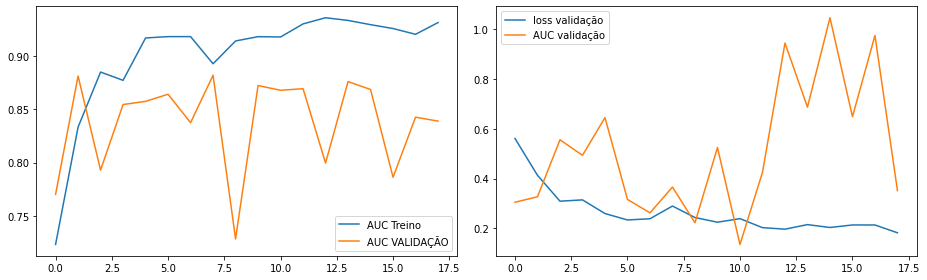

In [11]:
# MELHOR 109/109 [==============================] - 506s 5s/step - loss: 0.1973 - accuracy: 0.9293 - val_loss: 0.0946 - val_accuracy: 0.9259
#Epoch 00015: val_accuracy improved from 0.91647 to 0.92593, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/DenseNet121-v9-.h5

from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(64, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(64, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint('DenseNet121.h5',
                             monitor='val_accuracy',
                             mode="max",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

### Teste 2

/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1859 images belonging to 3 classes.
Found 465 images belonging to 3 classes.
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_________

conv3_block8_2_conv (Conv2D)    (None, 28, 28, 32)   36864       conv3_block8_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block8_concat (Concatenat (None, 28, 28, 384)  0           conv3_block7_concat[0][0]        
                                                                 conv3_block8_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block9_0_bn (BatchNormali (None, 28, 28, 384)  1536        conv3_block8_concat[0][0]        
__________________________________________________________________________________________________
conv3_block9_0_relu (Activation (None, 28, 28, 384)  0           conv3_block9_0_bn[0][0]          
__________________________________________________________________________________________________
conv3_block9_1_conv (Conv2D)    (None, 28, 28, 128)  49152       conv3_block9_0_relu[0][0]        
__________

Epoch 1/100
116/116 [==============================] - 97s 835ms/step - loss: 0.6379 - accuracy: 0.6687 - val_loss: 0.4435 - val_accuracy: 0.8369

Epoch 00001: val_accuracy improved from inf to 0.83693, saving model to DenseNet121b.h5
Epoch 2/100
116/116 [==============================] - 84s 720ms/step - loss: 0.4059 - accuracy: 0.8179 - val_loss: 0.3372 - val_accuracy: 0.8634

Epoch 00002: val_accuracy did not improve from 0.83693
Epoch 3/100
116/116 [==============================] - 68s 589ms/step - loss: 0.2772 - accuracy: 0.8926 - val_loss: 0.2201 - val_accuracy: 0.8708

Epoch 00003: val_accuracy did not improve from 0.83693
Epoch 4/100
116/116 [==============================] - 57s 490ms/step - loss: 0.2676 - accuracy: 0.9029 - val_loss: 0.4207 - val_accuracy: 0.8649

Epoch 00004: val_accuracy did not improve from 0.83693
Epoch 5/100
116/116 [==============================] - 56s 487ms/step - loss: 0.2554 - accuracy: 0.8994 - val_loss: 0.5046 - val_accuracy: 0.8055

Epoch 00005:

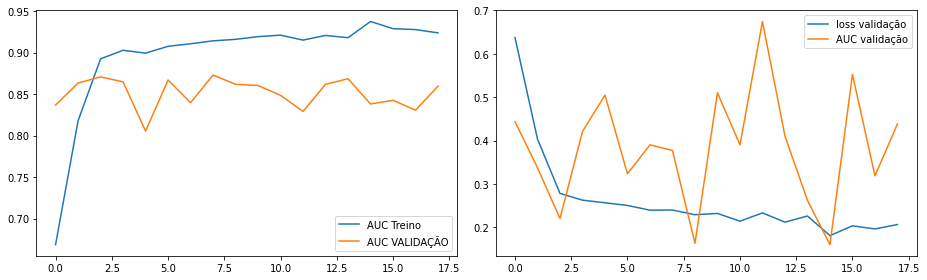

In [14]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
    
  top_model = Dense(64, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(32, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint('DenseNet121b.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

### Teste 3

/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1859 images belonging to 3 classes.
Found 465 images belonging to 3 classes.
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_________

conv3_block8_concat (Concatenat (None, 28, 28, 384)  0           conv3_block7_concat[0][0]        
                                                                 conv3_block8_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block9_0_bn (BatchNormali (None, 28, 28, 384)  1536        conv3_block8_concat[0][0]        
__________________________________________________________________________________________________
conv3_block9_0_relu (Activation (None, 28, 28, 384)  0           conv3_block9_0_bn[0][0]          
__________________________________________________________________________________________________
conv3_block9_1_conv (Conv2D)    (None, 28, 28, 128)  49152       conv3_block9_0_relu[0][0]        
__________________________________________________________________________________________________
conv3_block9_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block9_1_conv[0][0]        
__________

Epoch 1/100
116/116 [==============================] - 54s 466ms/step - loss: 0.6580 - accuracy: 0.6482 - val_loss: 0.5467 - val_accuracy: 0.6767

Epoch 00001: val_accuracy improved from inf to 0.67672, saving model to DenseNet121c.h5
Epoch 2/100
116/116 [==============================] - 58s 503ms/step - loss: 0.4906 - accuracy: 0.7424 - val_loss: 0.3151 - val_accuracy: 0.8322

Epoch 00002: val_accuracy did not improve from 0.67672
Epoch 3/100
116/116 [==============================] - 58s 496ms/step - loss: 0.4002 - accuracy: 0.7911 - val_loss: 0.2115 - val_accuracy: 0.8649

Epoch 00003: val_accuracy did not improve from 0.67672
Epoch 4/100
116/116 [==============================] - 57s 490ms/step - loss: 0.3528 - accuracy: 0.8293 - val_loss: 0.3376 - val_accuracy: 0.8738

Epoch 00004: val_accuracy did not improve from 0.67672
Epoch 5/100
116/116 [==============================] - 56s 484ms/step - loss: 0.3032 - accuracy: 0.8551 - val_loss: 0.4159 - val_accuracy: 0.8664

Epoch 00005:

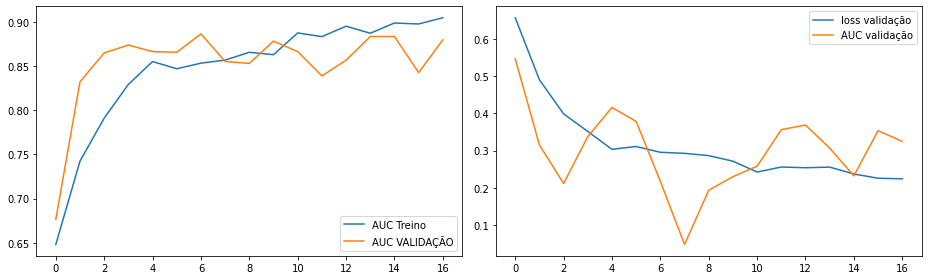

In [15]:
#melhores até agora neste modelo
#Epoch 98/100
#109/109 [==============================] - 59s 542ms/step - loss: 0.1392 - accuracy: 0.9486 - val_loss: 0.1121 - val_accuracy: 0.9196
#Epoch 99/100
#109/109 [==============================] - 59s 544ms/step - loss: 0.1247 - accuracy: 0.9547 - val_loss: 0.2072 - val_accuracy: 0.9377

from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(32, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint('DenseNet121c.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

### teste 3.1

In [ ]:
#melhores até agora neste modelo
#Epoch 98/100
#109/109 [==============================] - 59s 542ms/step - loss: 0.1392 - accuracy: 0.9486 - val_loss: 0.1121 - val_accuracy: 0.9196
#Epoch 99/100
#109/109 [==============================] - 59s 544ms/step - loss: 0.1247 - accuracy: 0.9547 - val_loss: 0.2072 - val_accuracy: 0.9377

from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(32, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint('DenseNet121d.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

/home/jimi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1859 images belonging to 3 classes.
Found 465 images belonging to 3 classes.
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_________

Epoch 1/100
116/116 [==============================] - 286s 2s/step - loss: 0.5693 - accuracy: 0.6949 - val_loss: 0.4372 - val_accuracy: 0.7737

Epoch 00001: val_accuracy improved from inf to 0.77371, saving model to DenseNet121d.h5
Epoch 2/100
 43/116 [==========>...................] - ETA: 2:21 - loss: 0.4598 - accuracy: 0.7926

In [ ]:
#melhores até agora neste modelo
#Epoch 98/100
#109/109 [==============================] - 59s 542ms/step - loss: 0.1392 - accuracy: 0.9486 - val_loss: 0.1121 - val_accuracy: 0.9196
#Epoch 99/100
#109/109 [==============================] - 59s 544ms/step - loss: 0.1247 - accuracy: 0.9547 - val_loss: 0.2072 - val_accuracy: 0.9377

from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(32, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint('DenseNet121d.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

## Testes com SGD

### Teste 4

In [ ]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint('DenseNet121d.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

### Teste 5

In [ ]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint('DenseNet121e.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

### Teste 6

In [ ]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(32, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint('DenseNet121f.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

In [ ]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(32, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint('DenseNet121g.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

In [ ]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(32, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint('DenseNet121h.h5',
                             monitor='val_accuracy',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))